In [35]:
# Import
%matplotlib inline
from collections import Counter
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from scipy.stats import multivariate_normal
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [36]:
#Make the plot larger
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [37]:
#Load datasets
data_traintest = pd.read_csv('00-17stats.csv')
data_predict = pd.read_csv('17-18stats.csv')
data_result = pd.read_csv('17-18stats.csv')
print(data_traintest.shape)
data_traintest.head()

(10221, 52)


,Voting,Rk,Year,Player,Pos,Age,Tm,G,GS,MP,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0.0,14470,2000.0,Tariq Abdul-Wahad,SG,25.0,TOT,61.0,56.0,1578.0,...,0.756,101.0,190.0,291.0,98.0,59.0,28.0,106.0,147.0,697.0
1,0.0,14471,2000.0,Tariq Abdul-Wahad,SG,25.0,ORL,46.0,46.0,1205.0,...,0.762,77.0,162.0,239.0,72.0,53.0,16.0,87.0,116.0,563.0
2,0.0,14472,2000.0,Tariq Abdul-Wahad,SG,25.0,DEN,15.0,10.0,373.0,...,0.738,24.0,28.0,52.0,26.0,6.0,12.0,19.0,31.0,134.0
3,0.0,14473,2000.0,Shareef Abdur-Rahim,SF,23.0,VAN,82.0,82.0,3223.0,...,0.809,218.0,607.0,825.0,271.0,89.0,87.0,249.0,244.0,1663.0
4,0.0,14474,2000.0,Cory Alexander,PG,26.0,DEN,29.0,2.0,329.0,...,0.773,8.0,34.0,42.0,58.0,24.0,2.0,28.0,39.0,82.0


In [38]:
#Data cleaning
#Fill NA values
data_traintest.fillna(data_traintest.mean(),inplace=True) 
data_predict.fillna(data_predict.mean(),inplace=True) 
data_result.fillna(data_result.mean(),inplace=True)
#Drop 'string' columns and useless columns
data_traintest.drop('Player',axis=1, inplace=True)
data_traintest.drop('Tm',axis=1, inplace=True)
data_traintest.drop('Pos',axis=1, inplace=True)
data_traintest.drop('Rk',axis=1, inplace=True)
data_predict.drop('Player',axis=1, inplace=True)
data_predict.drop('Tm',axis=1, inplace=True)
data_predict.drop('Pos',axis=1, inplace=True)
data_predict.drop('Rk',axis=1, inplace=True)

<font size=5 face="黑体">Threshold and Requirements</font>

*Every player must put up a PER of at least 18.5 in the season.

*Every player need to get an average of at least 0.20 WS/48 in the season.

*Every player plays  at least 1500 minutes in the season.

In [39]:
data_traintest = data_traintest[data_traintest.MP >= 1500]
data_traintest = data_traintest[data_traintest.PER >= 18.5]
data_traintest = data_traintest[data_traintest.WS/48 > 0.2]
data_predict = data_predict[data_predict.MP >= 1500]
data_predict = data_predict[data_predict.PER >= 18.5]
data_predict = data_predict[data_predict.WS/48 > 0.2]
data_result = data_result[data_result.MP >= 1500]
data_result = data_result[data_result.PER >= 18.5]
data_result = data_result[data_result.WS/48 > 0.2]

<font size=5 face="黑体">Because our target value, voting rates, is a decimal, we raise it by 1000 times to make the results more obvious.</font>

In [40]:
data_traintest['Voting'] = data_traintest['Voting']*1000

In [41]:
data_traintest

,Voting,Year,Age,G,GS,MP,PER,TS%,3PAr,FTr,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
5,0.0,2000.0,24.0,82.0,82.0,3070.0,20.6,0.570,0.288,0.282,...,0.887,83.0,276.0,359.0,308.0,110.0,19.0,183.0,187.0,1809.0
67,0.0,2000.0,21.0,66.0,62.0,2524.0,21.7,0.546,0.122,0.341,...,0.821,108.0,308.0,416.0,323.0,106.0,62.0,182.0,220.0,1485.0
83,42.0,2000.0,23.0,82.0,82.0,3126.0,23.4,0.543,0.139,0.325,...,0.791,150.0,326.0,476.0,322.0,110.0,92.0,178.0,263.0,2107.0
137,205.0,2000.0,23.0,74.0,74.0,2875.0,24.8,0.555,0.009,0.471,...,0.761,262.0,656.0,918.0,234.0,66.0,165.0,242.0,210.0,1716.0
162,337.0,2000.0,23.0,81.0,81.0,3243.0,23.6,0.545,0.053,0.265,...,0.765,223.0,733.0,956.0,401.0,120.0,126.0,268.0,205.0,1857.0
201,0.0,2000.0,27.0,74.0,74.0,2776.0,24.5,0.565,0.069,0.425,...,0.795,97.0,393.0,490.0,385.0,103.0,43.0,240.0,190.0,1906.0
240,0.0,2000.0,28.0,72.0,72.0,2807.0,19.9,0.555,0.305,0.374,...,0.864,81.0,262.0,343.0,305.0,192.0,49.0,160.0,176.0,1446.0
283,258.0,2000.0,36.0,82.0,82.0,2947.0,27.1,0.582,0.005,0.501,...,0.797,169.0,610.0,779.0,304.0,79.0,71.0,231.0,229.0,2095.0
322,303.0,2000.0,29.0,79.0,78.0,2748.0,25.8,0.596,0.003,0.492,...,0.711,215.0,538.0,753.0,123.0,40.0,294.0,217.0,308.0,1718.0
328,0.0,2000.0,33.0,82.0,82.0,2984.0,19.4,0.621,0.000,0.735,...,0.708,304.0,853.0,1157.0,105.0,27.0,269.0,174.0,248.0,942.0


In [42]:
# Get dimensions of train&test dataset
n = data_traintest.shape[0]
p = data_traintest.shape[1]

In [43]:
# Make data a np.array
data_traintest = data_traintest.values
data_predict = data_predict.values
data_result = data_result.values

In [44]:
#Get training and testing data
#Set start index and end index of training and testing data
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end + 1
test_end = n
data_train = data_traintest[np.arange(train_start, train_end), :]
data_test = data_traintest[np.arange(test_start, test_end), :]

In [45]:
#Build X and y
X_train = data_train[:, 1:]
y_train = data_train[:, 0]
X_test = data_test[:, 1:]
y_test = data_test[:, 0]

In [46]:
#Start creating RNN model and seting variables

# Number of player in training data
n_player = X_train.shape[1]

# Neurons
n_neurons_1 = 2048
n_neurons_2 = 1024
n_neurons_3 = 512
n_neurons_4 = 256
n_neurons_5 = 128

In [47]:
# Session
net = tf.InteractiveSession()

In [48]:
# Placeholder
X = tf.placeholder(dtype=tf.float32, shape=[None, n_player])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

In [49]:
# Initializers--tf.zeros_initializer
# Initializers are used to initialize the network’s variables before training.
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

In [50]:
# Hidden weights and biases
W_hidden_1 = tf.Variable(weight_initializer([n_player, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))
W_hidden_5 = tf.Variable(weight_initializer([n_neurons_4, n_neurons_5]))
bias_hidden_5 = tf.Variable(bias_initializer([n_neurons_5]))

In [51]:
# Output weights and biases
W_out = tf.Variable(weight_initializer([n_neurons_5, 1]))
bias_out = tf.Variable(bias_initializer([1]))

In [52]:
# Hidden layer(leaky_relu)
hidden_1 = tf.nn.leaky_relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))# 
hidden_2 = tf.nn.leaky_relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.leaky_relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.leaky_relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))
hidden_5 = tf.nn.leaky_relu(tf.add(tf.matmul(hidden_4, W_hidden_5), bias_hidden_5))

In [53]:
# Output layer (transpose!)
out = tf.transpose(tf.add(tf.matmul(hidden_5, W_out), bias_out))

In [54]:
# Cost function--user defined
# MSE computes the average squared deviation between predictions and targets
mse = tf.reduce_mean(tf.squared_difference(out, Y))

In [55]:
# Optimizer--Adam
# Used to compute and adapt weights and biases
opt = tf.train.AdamOptimizer().minimize(mse)

In [56]:
#initialize variables
init = tf.global_variables_initializer()

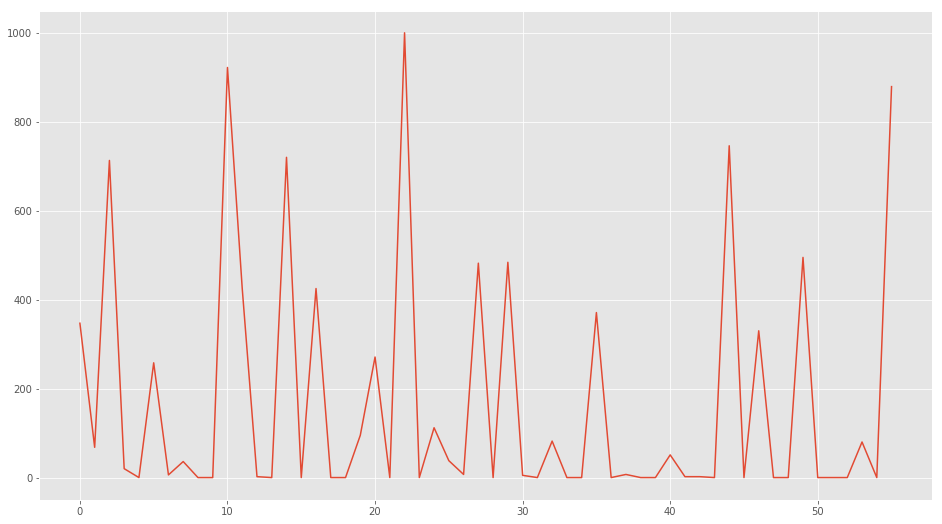

In [57]:
# Setup plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
#line2, = ax1.plot(y_test * 2)
plt.show()

<font size=5 face="黑体">Fitting the RNN model</font>

In [67]:
# Number of iterations or training cycles
epochs = 4000

In [72]:
#Run the model
#Display the changing process of mse every 500 epochs
with tf.Session() as sess:
    init.run()
    for e in range(epochs):
        sess.run(opt, feed_dict={X: X_train, Y: y_train})
        if e % 500 == 0:
            loss = mse.eval(feed_dict={X: X_train, Y: y_train})
            print(e, "\tMSE:", loss)
            
    y_pred = sess.run(out, feed_dict={X: X_test})
    # Predict MVP of new season
    MVP = sess.run(out, feed_dict={X: data_predict})

0 	MSE: 666611.0
500 	MSE: 11845.2
1000 	MSE: 543.912
1500 	MSE: 39169.2
2000 	MSE: 27.3785
2500 	MSE: 92.5267
3000 	MSE: 13.6071
3500 	MSE: 1.3433


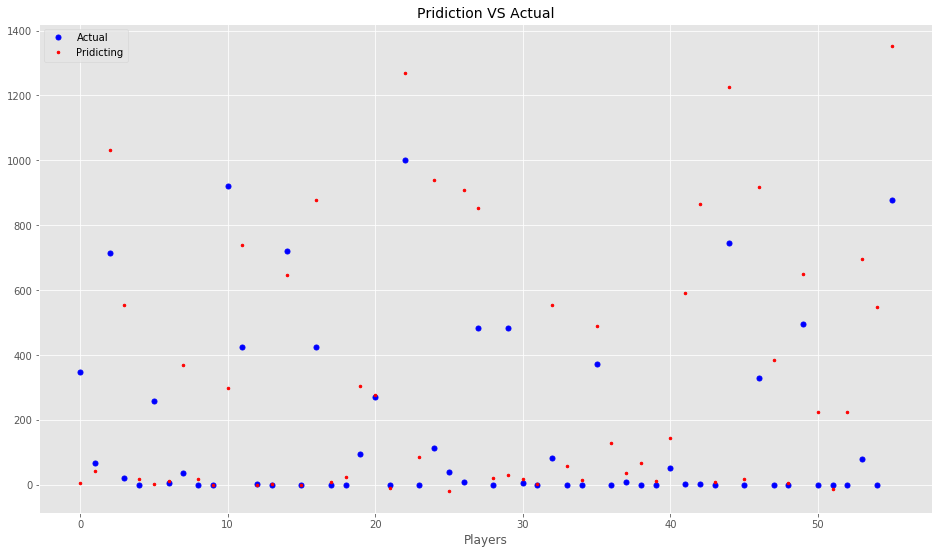

In [73]:
#First observe the accuracy of the predicting results and actual values of test data.
#Make the plot
plt.title("Pridiction VS Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(y_test)), "bo", markersize = 5, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize = 5, label="Pridicting")
plt.legend(loc="upper left")
plt.xlabel("Players")

plt.show()

Copyright 2017 Sebastian Heinz

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
    
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<font size=5 face="黑体">Predict MVP in 17-18 season</font>

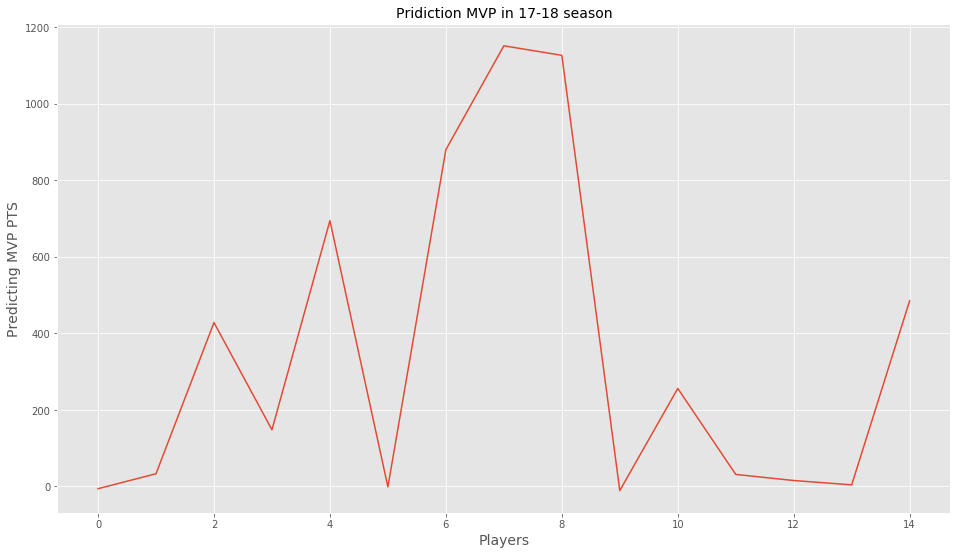

In [94]:
#Make the plot of predicting results of new season data
plt.title("Pridiction MVP in 17-18 season", fontsize=14)
plt.plot(pd.Series(np.ravel(MVP)))
plt.ylabel("Predicting MVP PTS", fontsize=14)
plt.xlabel("Players", fontsize=14)

plt.show()

<font size=5 face="黑体">Show specific players intuitively</font>

In [84]:
#Because the shape of MVP value array and Player array is different, transpose it.
MVP = MVP.T

In [144]:
#Combine the arrays and match the predicting results to the players.
Players = np.concatenate((data_result,MVP),axis=1)

In [155]:
#Sort players in desending order for MVP value
Players = Players[Players[:,51].argsort()][::-1]

In [156]:
Players

array([[194, 2018, 'James Harden\\hardeja01', 'SG', 28, 'HOU', 72, 72,
        2551, 29.8, 0.619, 0.498, 0.502, 1.8, 15.2, 8.6, 45.1, 2.4, 1.7,
        15.1, 36.1, 11.6, 3.8, 15.4, 0.289, 9.6, 1.3, 10.9, 8.3, 651, 1449,
        0.449, 265, 722, 0.36700000000000005, 386, 727, 0.531, 0.541, 624,
        727, 0.858, 41, 348, 389, 630, 126, 50, 315, 169, 2191,
        1150.86669921875],
       [248, 2018, 'LeBron James\\jamesle01', 'PF', 33, 'CLE', 82, 82,
        3026, 28.6, 0.621, 0.257, 0.336, 3.7, 22.3, 13.1, 44.4, 1.9, 2.0,
        16.1, 31.6, 11.0, 3.0, 14.0, 0.221, 7.6, 2.0, 9.6, 8.9, 857, 1580,
        0.542, 149, 406, 0.36700000000000005, 708, 1174, 0.603, 0.59, 388,
        531, 0.731, 97, 612, 709, 747, 116, 71, 347, 135, 2251,
        1125.987060546875],
       [143, 2018, 'Kevin Durant\\duranke01', 'PF', 29, 'GSW', 68, 68,
        2325, 26.0, 0.64, 0.33799999999999997, 0.331, 1.6, 19.5, 11.2,
        25.5, 1.0, 4.0, 12.9, 30.4, 7.5, 2.9, 10.4, 0.215, 5.0, 0.7, 5.6,
        4.5

<font size=5 face="黑体">Conclusion</font>

Through the array above, we could make the conclusion that James Harden will win MVP of 17-18 NBA season in our model. LeBron James and Kevin Durant are in second and third place respectively.